# Project name: Customer Segmentation for E-commerce

Category:  Machine Learning, Customer Analytics

Importance: Identify customer segments based on behavior for targeted marketing and personalization.

Levels:
Level 1: Basic segmentation using RFM analysis.

Level 2: Incorporate machine learning clustering algorithms.

Level 3: Compairing RFM with clustering algorithms.

# Challenges

1. Should have to know RFM
2. Rules to segmantation without ML
3. K means clustering 

# RFM

1. Recency (R): Refers to the time since a customer's last purchase. It measures how recently a customer has interacted or made a purchase. The assumption is that more recent customers are likely to be more engaged and responsive.

2. Frequency (F): Represents the number of times a customer has made a purchase within a given period. It indicates the level of engagement and loyalty. Higher frequency often suggests a more loyal customer.

3. Monetary Value (M): Reflects the total amount of money a customer has spent on purchases. It measures the customer's contribution to the business in terms of revenue. Higher monetary value indicates customers who are more valuable to the business.

Import libraries for reading, preprocessing and vizualization 

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import missingno as msno
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

In [11]:
path = r'G:\Final project24\RFM-24\Sales Data.xlsx'
df = pd.read_excel(path)
df.head()

,Order ID,Order Date,Customer ID,Customer Name,Product ID,Sales
0,CA-2021-152156,2021-08-11,CG-12520,Claire Gute,FUR-BO-10001798,261.9600
1,CA-2021-152156,2021-08-11,CG-12520,Claire Gute,FUR-CH-10000454,731.9400
2,CA-2021-138688,2021-12-06,DV-13045,Darrin Van Huff,OFF-LA-10000240,14.6200
3,US-2020-108966,2020-11-10,SO-20335,Sean O'Donnell,FUR-TA-10000577,957.5775
4,US-2020-108966,2020-11-10,SO-20335,Sean O'Donnell,OFF-ST-10000760,22.3680


# Data preprocessing

In [12]:
df.shape

(3220, 6)

In [13]:
df.columns

Index(['Order ID', 'Order Date', 'Customer ID', 'Customer Name', 'Product ID',
       'Sales'],
      dtype='object')

In [14]:
df.isnull().sum()

Order ID         27
Order Date       24
Customer ID      24
Customer Name    20
Product ID       24
Sales            24
dtype: int64

<Figure size 800x500 with 0 Axes>

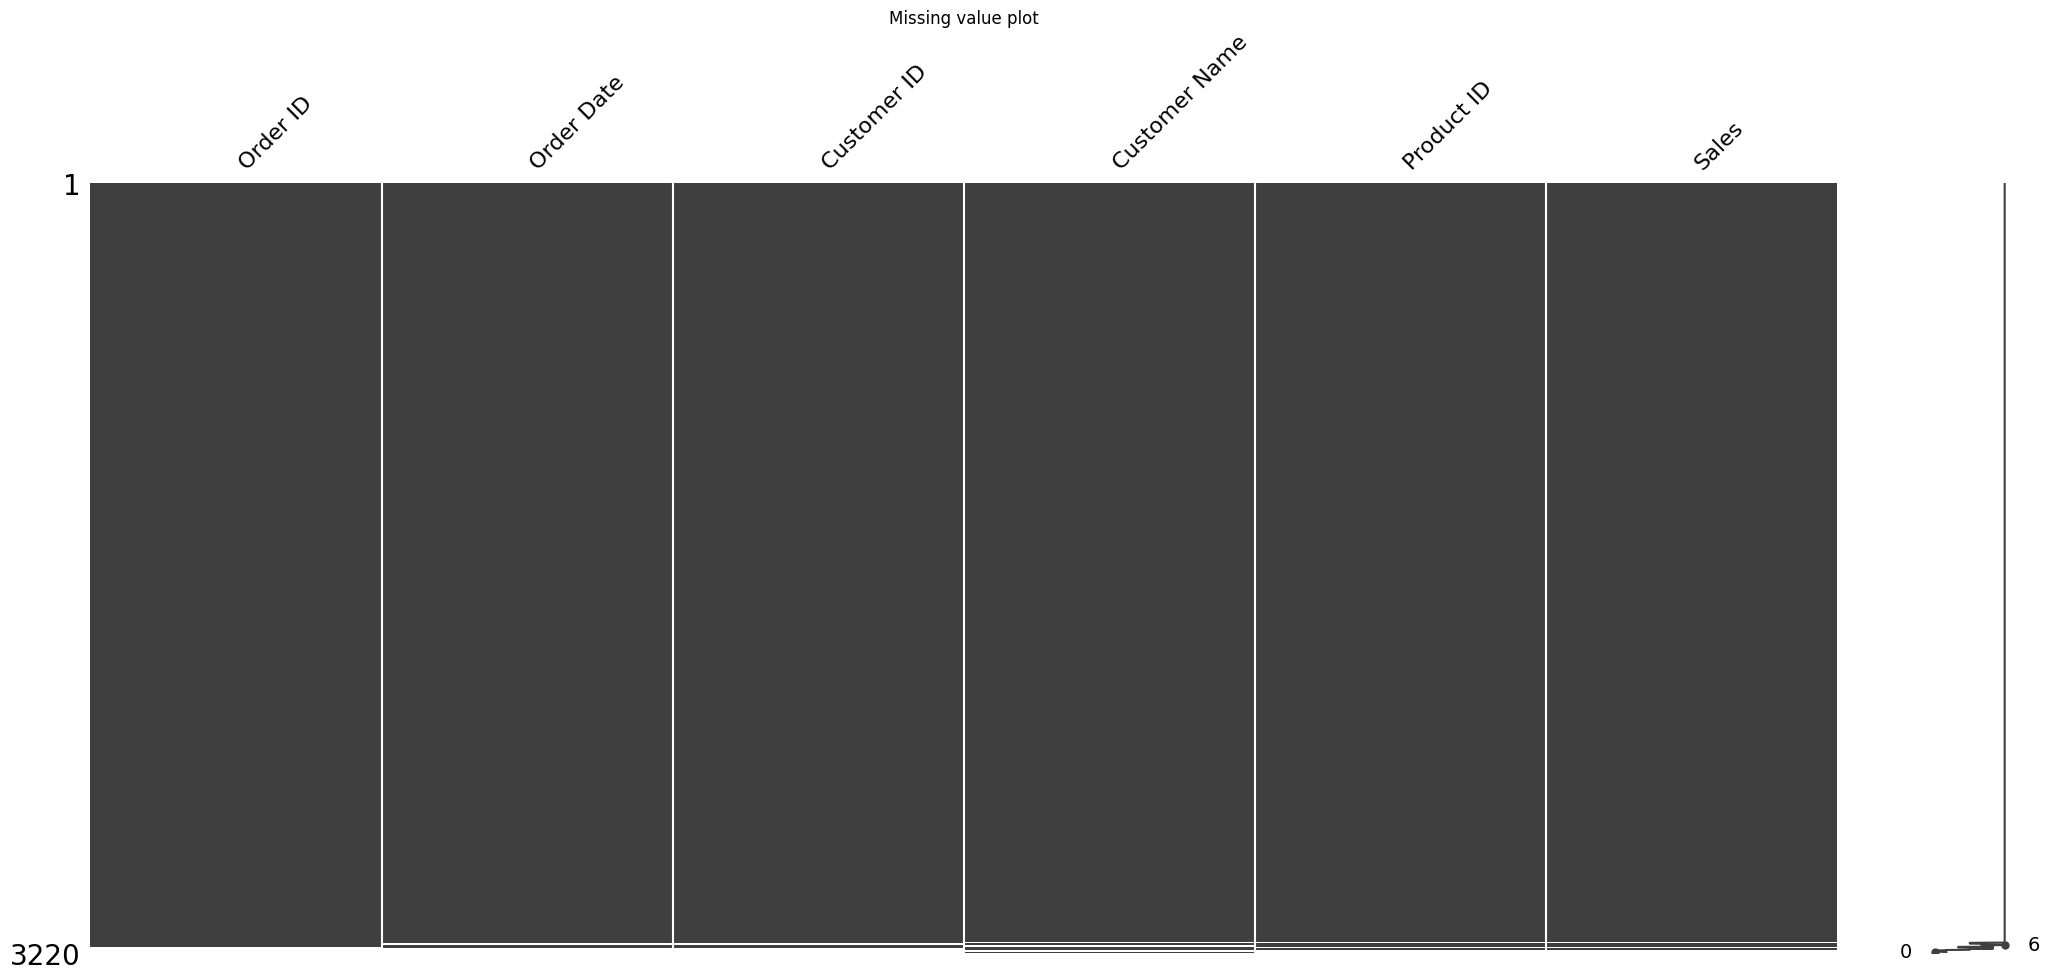

In [15]:
plt.figure(figsize=(8,5))

msno.matrix(df)
plt.title('Missing value plot')

plt.show()

In [16]:
# Find percentage wise null
null_count = df.isnull().sum()
null_percentage = ((df.isnull().sum()/len(df))*100).round(2)

result_df = pd.DataFrame({"Null counts": null_count[null_count>0],"null percentage": null_percentage[null_count>0]})

print(result_df)

               Null counts  null percentage
Order ID                27             0.84
Order Date              24             0.75
Customer ID             24             0.75
Customer Name           20             0.62
Product ID              24             0.75
Sales                   24             0.75


In [17]:
df.dropna(inplace = True)

In [18]:
df.isnull().sum()

Order ID         0
Order Date       0
Customer ID      0
Customer Name    0
Product ID       0
Sales            0
dtype: int64

In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3177 entries, 0 to 3185
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Order ID       3177 non-null   object        
 1   Order Date     3177 non-null   datetime64[ns]
 2   Customer ID    3177 non-null   object        
 3   Customer Name  3177 non-null   object        
 4   Product ID     3177 non-null   object        
 5   Sales          3177 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(4)
memory usage: 173.7+ KB


In [20]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())
    print("-" * 100)

Order ID
Order ID
CA-2022-157987    12
US-2021-108504    11
CA-2021-165330    11
CA-2020-131338    10
CA-2022-117457     9
                  ..
CA-2021-151092     1
CA-2020-120397     1
CA-2022-150602     1
CA-2022-115105     1
CA-2020-158659     1
Name: count, Length: 1600, dtype: int64
----------------------------------------------------------------------------------------------------
Order Date
Order Date
2021-05-09    38
2021-10-11    35
2022-01-12    34
2022-02-12    34
2022-09-12    33
              ..
2021-07-08     1
2020-08-07     1
2022-06-01     1
2022-04-10     1
2020-09-05     1
Name: count, Length: 360, dtype: int64
----------------------------------------------------------------------------------------------------
Customer ID
Customer ID
PP-18955    21
LC-16870    17
NS-18640    17
WB-21850    17
BF-11020    17
            ..
MN-17935     1
GA-14515     1
TB-21520     1
GM-14695     1
TT-21265     1
Name: count, Length: 697, dtype: int64
---------------------------------

In [21]:
for col in df.describe(include = 'object').columns:
    print(col)
    print(df[col].unique())
    print("-"*100)

Order ID
['CA-2021-152156' 'CA-2021-138688' 'US-2020-108966' ... 'CA-2021-104983'
 'CA-2020-155635' 'CA-2020-128608']
----------------------------------------------------------------------------------------------------
Customer ID
['CG-12520' 'DV-13045' 'SO-20335' 'IM-15070' 'KB-16585' 'GH-14485'
 'LC-16930' 'ON-18715' 'JM-15265' 'KD-16270' 'KB-16600' 'SC-20770'
 'JC-16105' 'GM-14455' 'RB-19705' 'PN-18775' 'ER-13855' 'GZ-14470'
 'CL-12565' 'DK-13090' 'GG-14650' 'SC-20725' 'TS-21610' 'LS-16975'
 'DW-13585' 'JD-15895' 'HA-14920' 'JE-16165' 'TT-21070' 'MJ-17740'
 'MP-17470' 'VM-21685' 'FH-14365' 'HK-14890' 'LE-16810' 'JH-15985'
 'MS-17980' 'VW-21775' 'DS-13180' 'CS-12400' 'DB-13120' 'KL-16645'
 'LH-17155' 'KC-16540' 'DL-13315' 'CC-12670' 'Dl-13600' 'RC-19825'
 'AH-10210' 'CA-12310' 'JO-15280' 'AS-10225' 'BP-11185' 'DJ-13510'
 'DB-13615' 'TD-20995' 'AB-10060' 'JL-15505' 'VB-21745' 'DK-13225'
 'MV-18190' 'AG-10675' 'KH-16510' 'KC-16675' 'SP-20860' 'KH-16630'
 'DB-13060' 'PO-19180' 'PK-19075

# EDA 

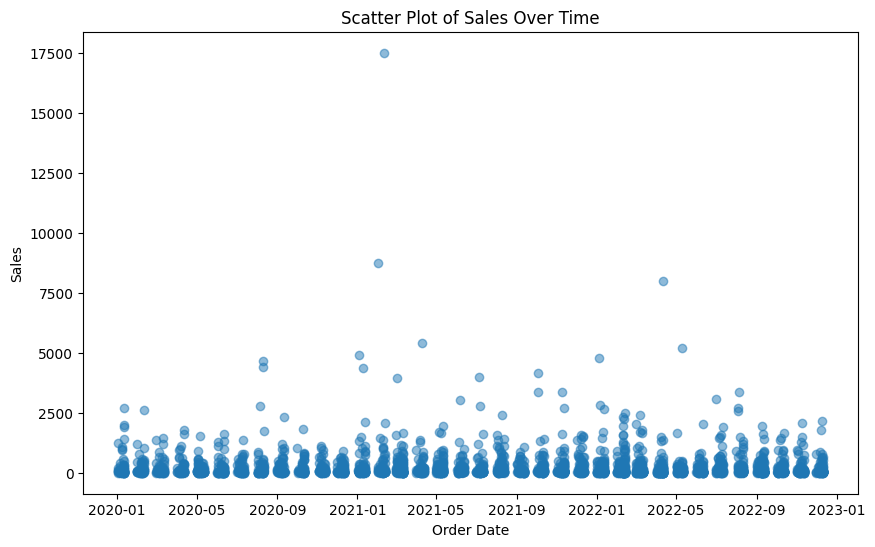

In [22]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df['Order Date'], df['Sales'], alpha=0.5)

# Set labels and title
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Scatter Plot of Sales Over Time')

# Show the plot
plt.show()

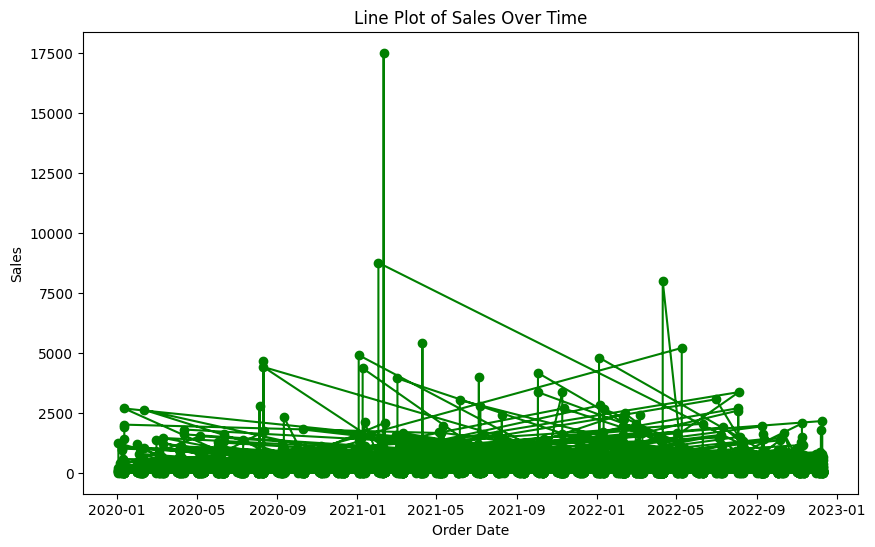

In [23]:
# Sort the DataFrame by 'Order Date' for a chronological line plot
#df = df.sort_values('Order Date')

# Line plot
plt.figure(figsize=(10, 6))
plt.plot(df['Order Date'], df['Sales'], marker='o', linestyle='-', color='g')

# Set labels and title
plt.xlabel('Order Date')
plt.ylabel('Sales')
plt.title('Line Plot of Sales Over Time')

# Show the plot
plt.show()

In [24]:
df.describe()

,Order Date,Sales
count,3177,3177.000000
mean,2021-08-16 19:14:26.855523840,218.895637
min,2020-01-03 00:00:00,0.556000
25%,2020-12-11 00:00:00,17.430000
50%,2021-09-12 00:00:00,54.992000
75%,2022-05-03 00:00:00,198.272000
max,2022-12-11 00:00:00,17499.950000
std,NaN,575.772530


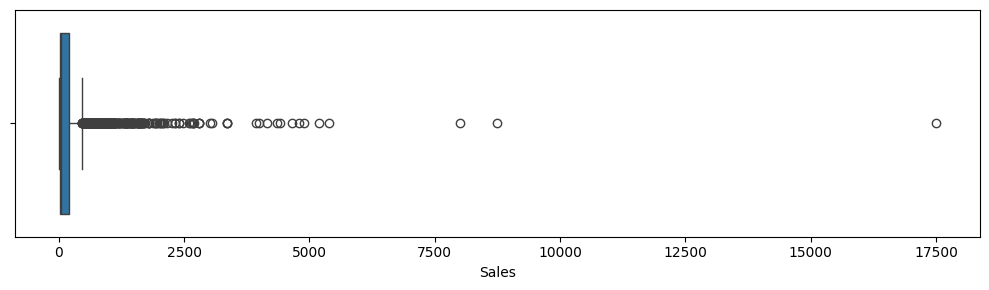

In [25]:
# Find outliers

plt.figure(figsize=(10, 3))

sns.boxplot(x=df["Sales"])
    
plt.tight_layout()
plt.show()

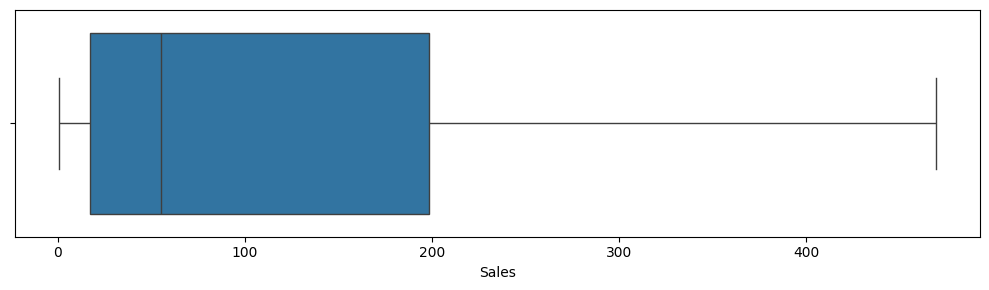

In [26]:
# Capping outliers using the IQR method

Q1 = df['Sales'].quantile(0.25)
Q3 = df['Sales'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bounds to cap outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Cap outliers by setting values beyond bounds to the bounds
df['Sales'] = df['Sales'].clip(lower=lower_bound, upper=upper_bound)

# Display the box plots after capping outliers
plt.figure(figsize=(10, 3))
sns.boxplot(x=df['Sales'])

plt.tight_layout()
plt.show()

In [27]:
df['Sales'].skew()

1.2147197464455306

Skewness after transformation: -0.011651772600385898


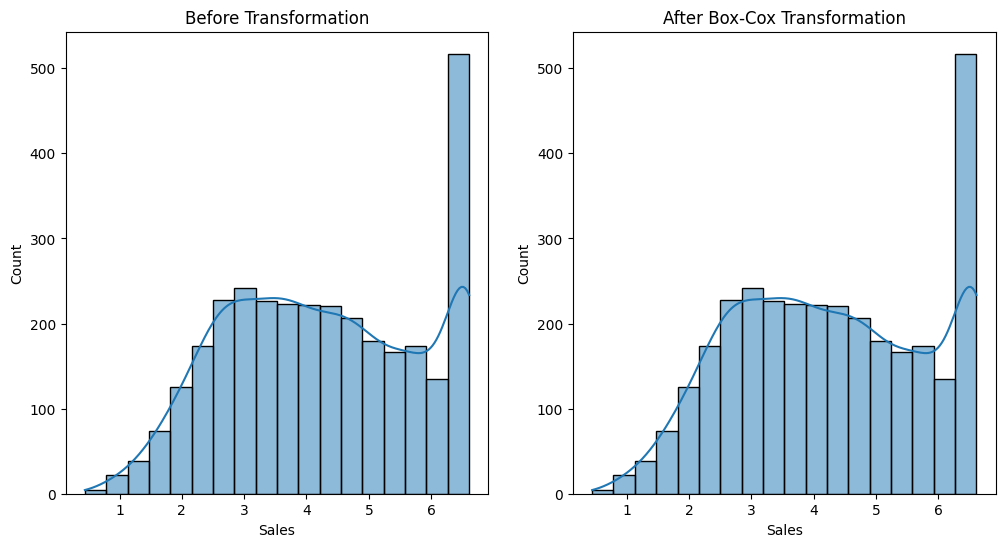

Optimal lambda value: 0.02296270352617798


In [28]:
from scipy.stats import boxcox

# Applying the Box-Cox transformation
df['Sales'], lambda_value = boxcox(df['Sales'] + 1)  # Adding 1 to handle zero values

# Checking the skewness after transformation
print("Skewness after transformation:", df['Sales'].skew())

# Plotting the distribution before and after transformation
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(df['Sales'], kde=True)
plt.title('Before Transformation')

plt.subplot(1, 2, 2)
sns.histplot(df['Sales'], kde=True)
plt.title('After Box-Cox Transformation')

plt.show()

# Print the lambda value
print("Optimal lambda value:", lambda_value)

In [29]:
df['Order Date'] = pd.to_datetime(df['Order Date'])

In [30]:
df.head()

,Order ID,Order Date,Customer ID,Customer Name,Product ID,Sales
0,CA-2021-152156,2021-08-11,CG-12520,Claire Gute,FUR-BO-10001798,5.944168
1,CA-2021-152156,2021-08-11,CG-12520,Claire Gute,FUR-CH-10000454,6.609895
2,CA-2021-138688,2021-12-06,DV-13045,Darrin Van Huff,OFF-LA-10000240,2.837142
3,US-2020-108966,2020-11-10,SO-20335,Sean O'Donnell,FUR-TA-10000577,6.609895
4,US-2020-108966,2020-11-10,SO-20335,Sean O'Donnell,OFF-ST-10000760,3.268191


In [31]:
df['Customer ID'].unique()

array(['CG-12520', 'DV-13045', 'SO-20335', 'IM-15070', 'KB-16585',
       'GH-14485', 'LC-16930', 'ON-18715', 'JM-15265', 'KD-16270',
       'KB-16600', 'SC-20770', 'JC-16105', 'GM-14455', 'RB-19705',
       'PN-18775', 'ER-13855', 'GZ-14470', 'CL-12565', 'DK-13090',
       'GG-14650', 'SC-20725', 'TS-21610', 'LS-16975', 'DW-13585',
       'JD-15895', 'HA-14920', 'JE-16165', 'TT-21070', 'MJ-17740',
       'MP-17470', 'VM-21685', 'FH-14365', 'HK-14890', 'LE-16810',
       'JH-15985', 'MS-17980', 'VW-21775', 'DS-13180', 'CS-12400',
       'DB-13120', 'KL-16645', 'LH-17155', 'KC-16540', 'DL-13315',
       'CC-12670', 'Dl-13600', 'RC-19825', 'AH-10210', 'CA-12310',
       'JO-15280', 'AS-10225', 'BP-11185', 'DJ-13510', 'DB-13615',
       'TD-20995', 'AB-10060', 'JL-15505', 'VB-21745', 'DK-13225',
       'MV-18190', 'AG-10675', 'KH-16510', 'KC-16675', 'SP-20860',
       'KH-16630', 'DB-13060', 'PO-19180', 'PK-19075', 'RB-19360',
       'KH-16690', 'MT-18070', 'SS-20590', 'EB-13705', 'MG-181

# RFM Anallysis with python

Calculating recency, frequency and monetry

In [32]:
# Calculate recency based on 'Order Date'
today = pd.to_datetime('2023-12-01')
df['Recency'] = (today - df['Order Date']).dt.days

# Calculate frequency
df['Frequency'] = df.groupby('Customer ID')['Order Date'].transform('count')

# Calculate monetary
df['Monetary'] = df.groupby('Customer ID')['Sales'].transform('sum')

df.head()

,Order ID,Order Date,Customer ID,Customer Name,Product ID,Sales,Recency,Frequency,Monetary
0,CA-2021-152156,2021-08-11,CG-12520,Claire Gute,FUR-BO-10001798,5.944168,842,2,12.554063
1,CA-2021-152156,2021-08-11,CG-12520,Claire Gute,FUR-CH-10000454,6.609895,842,2,12.554063
2,CA-2021-138688,2021-12-06,DV-13045,Darrin Van Huff,OFF-LA-10000240,2.837142,725,6,26.711267
3,US-2020-108966,2020-11-10,SO-20335,Sean O'Donnell,FUR-TA-10000577,6.609895,1116,12,55.668016
4,US-2020-108966,2020-11-10,SO-20335,Sean O'Donnell,OFF-ST-10000760,3.268191,1116,12,55.668016


In [33]:
df.drop(columns=['Order ID','Product ID'], inplace = True)

In [34]:
# Convert 'Order Date' to datetime if not already
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Group by 'Customer ID' and aggregate the values
agg_df = df.groupby('Customer ID').agg({
    'Order Date': 'first',
    'Customer Name': 'first',
    'Sales': 'sum',
    'Recency': 'sum',  # You can use mean or any other aggregation function depending on your requirement
    'Frequency': 'sum',  # Assuming you want the maximum frequency
    'Monetary': 'sum',
}).reset_index()

# Print the aggregated DataFrame
agg_df

,Customer ID,Order Date,Customer Name,Sales,Recency,Frequency,Monetary
0,AA-10315,2020-04-10,Alex Avila,21.718492,5342,25,108.592459
1,AA-10375,2021-10-07,Allen Armold,31.481124,6908,81,283.330120
2,AA-10645,2021-04-07,Anna Andreadi,36.192538,8305,81,325.732844
3,AB-10015,2021-10-11,Aaron Bergman,12.004048,1562,4,24.008097
4,AB-10060,2021-01-09,Adam Bellavance,51.958741,9115,144,623.504888
...,...,...,...,...,...,...,...
692,XP-21865,2021-01-11,Xylona Preis,50.891355,12796,196,712.478966
693,YC-21895,2021-07-04,Yoseph Carroll,19.649625,3775,16,78.598500
694,YS-21880,2022-03-07,Yana Sorensen,24.323488,4716,25,121.617438
695,ZC-21910,2021-08-03,Zuschuss Carroll,42.337717,6642,100,423.377169


Create bin

In [35]:
# Define scoring criteria for each RFM value
recency_scores = [5, 4, 3, 2, 1]  # Higher score for lower recency (more recent)
frequency_scores = [1, 2, 3, 4, 5]  # Higher score for higher frequency
monetary_scores = [1, 2, 3, 4, 5]  # Higher score for higher monetary value

# Calculate RFM scores
agg_df['RecencyScore'] = pd.cut(agg_df['Recency'], bins=5, labels=recency_scores)
agg_df['FrequencyScore'] = pd.cut(agg_df['Frequency'], bins=5, labels=frequency_scores)
agg_df['MonetaryScore'] = pd.cut(agg_df['Monetary'], bins=5, labels=monetary_scores)

# Convert RFM scores to numeric type
agg_df['RecencyScore'] = agg_df['RecencyScore'].astype(int)
agg_df['FrequencyScore'] = agg_df['FrequencyScore'].astype(int)
agg_df['MonetaryScore'] = agg_df['MonetaryScore'].astype(int)

# Calculate RFM score by combining the individual scores
agg_df['RFM_Score'] = agg_df['RecencyScore'] + agg_df['FrequencyScore'] + agg_df['MonetaryScore']

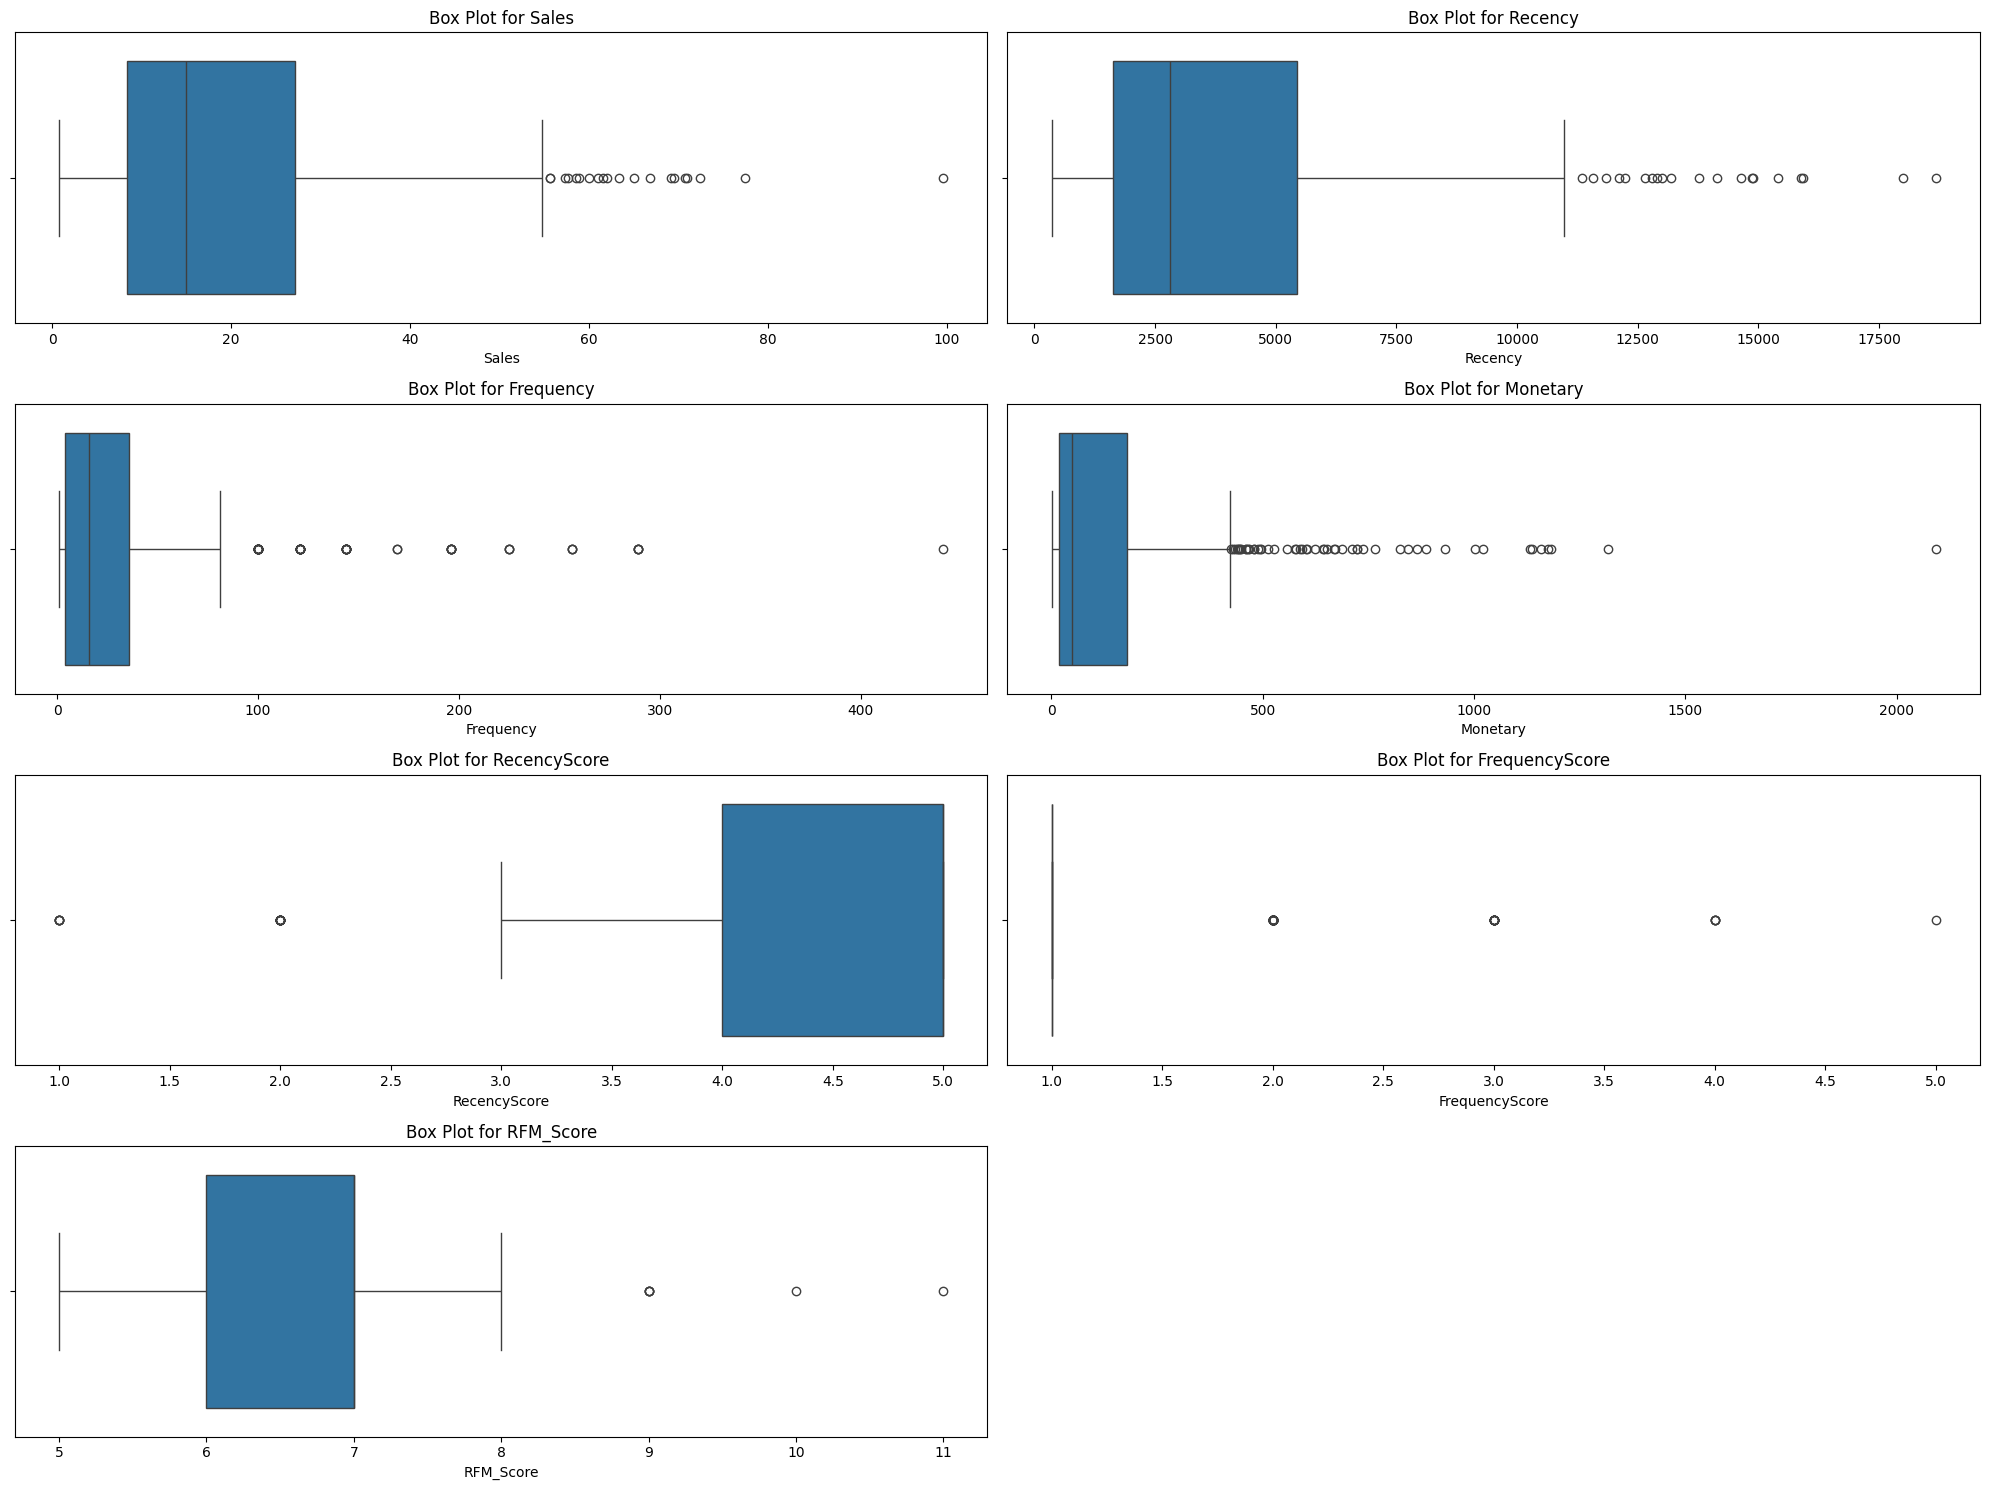

In [36]:
# List of columns for which you want to create box plots
columns_to_plot = ['Sales', 'Recency', 'Frequency', 'Monetary',
       'RecencyScore', 'FrequencyScore', 'RFM_Score']

# Set the size of the plot
plt.figure(figsize=(20, 15))

# Loop through the columns and create box plots
for i, column in enumerate(columns_to_plot, 1):
    plt.subplot(4, 2, i)  # Adjust the subplot grid as needed
    sns.boxplot(x=agg_df[column])
    plt.title(f'Box Plot for {column}')

plt.tight_layout()
plt.show()

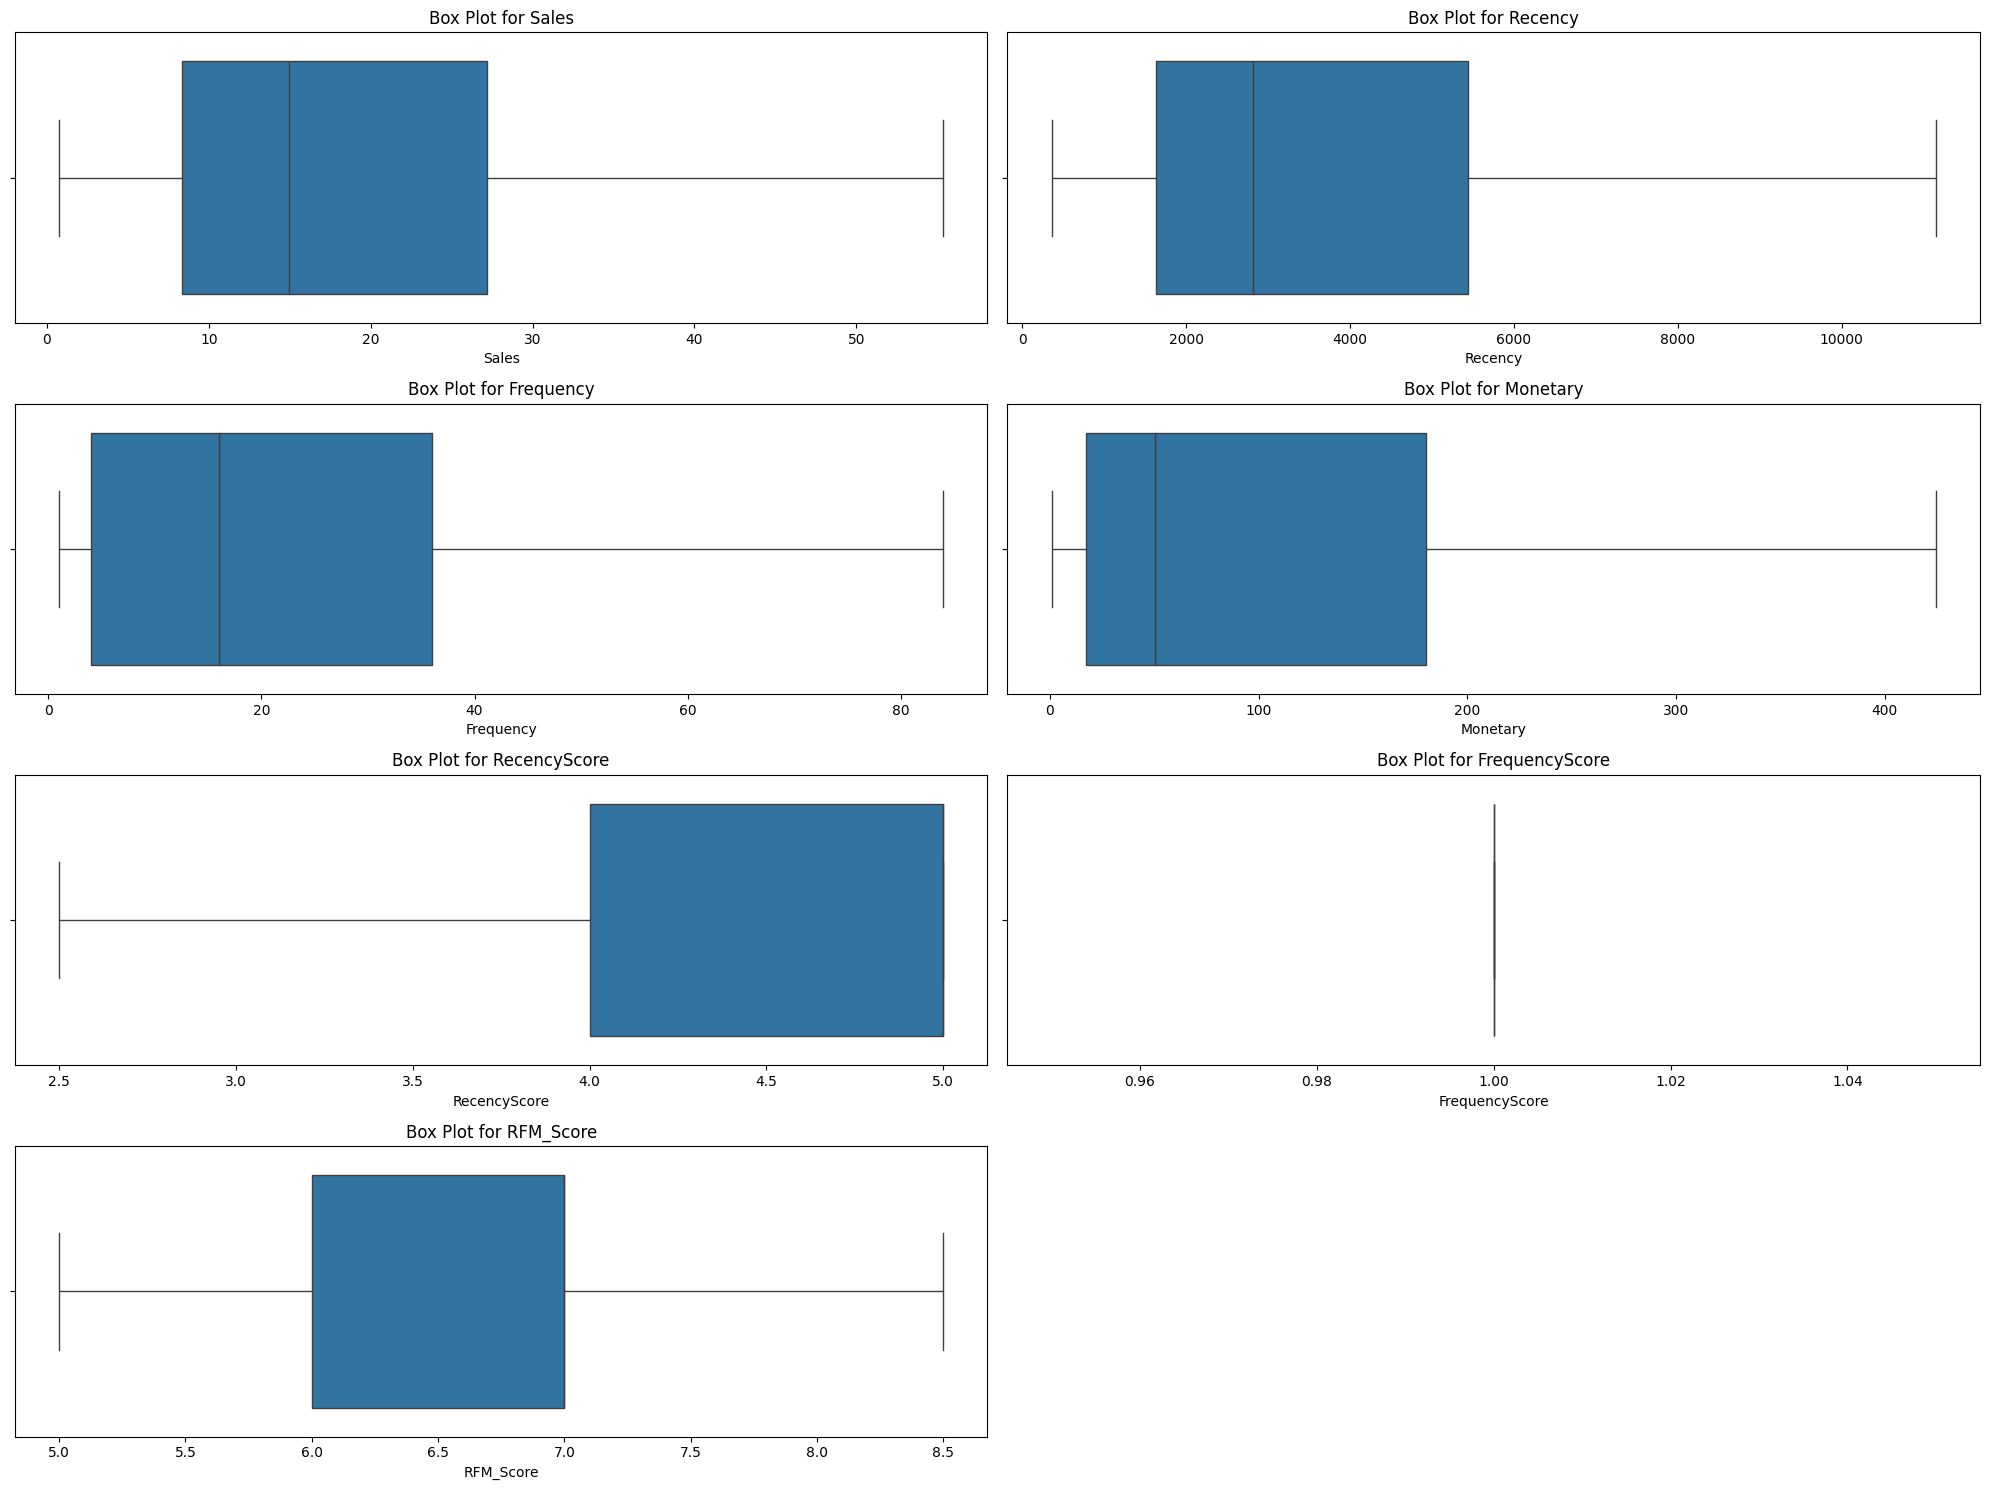

In [37]:
# List of columns for which you want to create box plots
columns_to_cap = ['Sales', 'Recency', 'Frequency', 'Monetary','RecencyScore', 'FrequencyScore', 'RFM_Score']

# Capping outliers using the IQR method

for column in columns_to_cap:
    Q1 = agg_df[column].quantile(0.25)
    Q3 = agg_df[column].quantile(0.75)
    IQR = Q3 - Q1
    # Define the lower and upper bounds to cap outliers
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    # Cap outliers by setting values beyond bounds to the bounds
    agg_df[column] = agg_df[column].clip(lower=lower_bound, upper=upper_bound)

# Display the box plots after capping outliers
plt.figure(figsize=(20, 15))

# Loop through the columns and create box plots
for i, column in enumerate(columns_to_cap, 1):
    plt.subplot(4, 2, i)  # Adjust the subplot grid as needed
    sns.boxplot(x=agg_df[column])
    plt.title(f'Box Plot for {column}')

plt.tight_layout()
plt.show()

In [38]:
agg_df.columns

Index(['Customer ID', 'Order Date', 'Customer Name', 'Sales', 'Recency',
       'Frequency', 'Monetary', 'RecencyScore', 'FrequencyScore',
       'MonetaryScore', 'RFM_Score'],
      dtype='object')

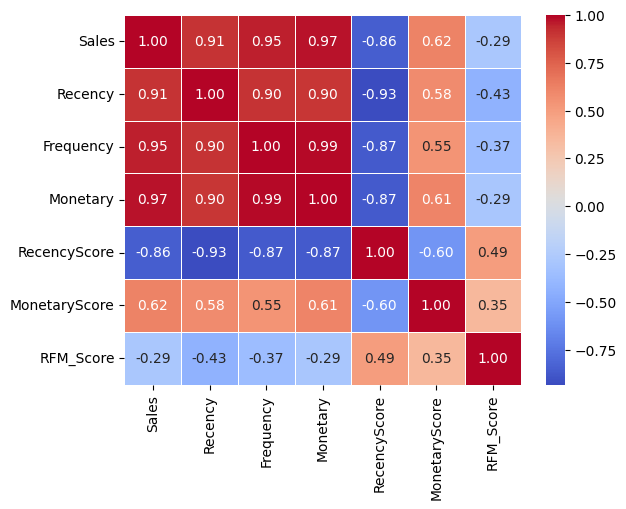

In [39]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and numeric_agg_df contains the numeric columns
numeric_agg_df = ['Sales', 'Recency','Frequency', 'Monetary', 'RecencyScore',
                 'MonetaryScore', 'RFM_Score']
corr_mat = agg_df[numeric_agg_df].corr()

sns.heatmap(corr_mat, annot=True, fmt=".2f", cmap="coolwarm", linewidth = 0.5)
plt.show()

In [40]:
agg_df['RFM_Score'].unique()

array([6. , 5. , 7. , 8. , 8.5])

In [41]:
# Create a new column for RFM Customer Segments
agg_df['RFM Customer Segments'] = ''

# Assign RFM segments based on RFM score thresholds
agg_df.loc[agg_df['RFM_Score'] >= 8, 'RFM Customer Segments'] = 'Top Customer'
agg_df.loc[(agg_df['RFM_Score'] >= 7) & (agg_df['RFM_Score'] < 8), 'RFM Customer Segments'] = 'High Value Customer'
agg_df.loc[(agg_df['RFM_Score'] >= 6) & (agg_df['RFM_Score'] < 7), 'RFM Customer Segments'] = 'Low Value Customer'
# agg_df.loc[(agg_df['RFM_Score'] >= 6) & (agg_df['RFM_Score'] < 7), 'RFM Customer Segments'] = "Low Value Customer"
agg_df.loc[(agg_df['RFM_Score'] < 6), 'RFM Customer Segments'] = "Lost Customer"

In [42]:
agg_df.head()

,Customer ID,Order Date,Customer Name,Sales,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,RFM Customer Segments
0,AA-10315,2020-04-10,Alex Avila,21.718492,5342.0,25,108.592459,4.0,1,1,6.0,Low Value Customer
1,AA-10375,2021-10-07,Allen Armold,31.481124,6908.0,81,283.330120,4.0,1,1,6.0,Low Value Customer
2,AA-10645,2021-04-07,Anna Andreadi,36.192538,8305.0,81,325.732844,3.0,1,1,5.0,Lost Customer
3,AB-10015,2021-10-11,Aaron Bergman,12.004048,1562.0,4,24.008097,5.0,1,1,7.0,High Value Customer
4,AB-10060,2021-01-09,Adam Bellavance,51.958741,9115.0,84,424.521661,3.0,1,2,7.0,High Value Customer


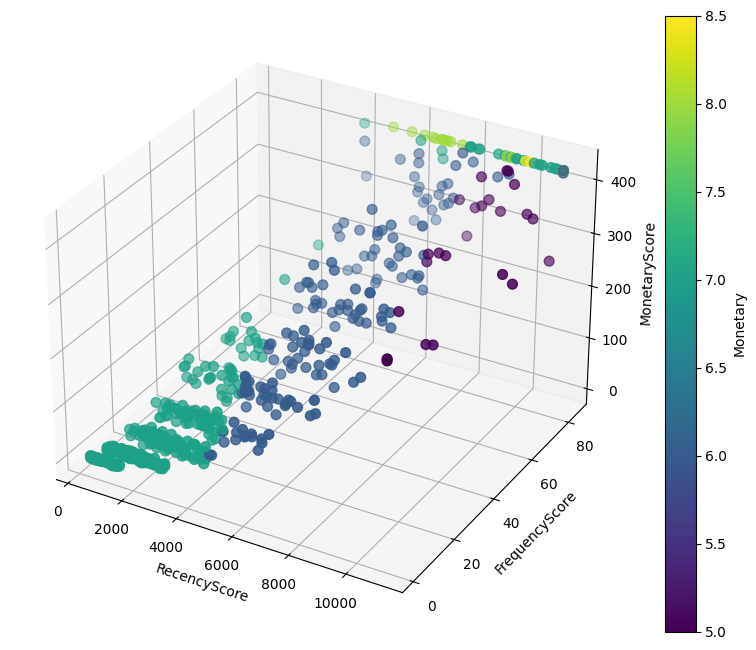

In [43]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

# Assuming you have three dimensions: Recency, Frequency, and Monetary
# Assuming 'Monetary' is the hue column
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with different colors based on the 'Monetary' column
scatter = ax.scatter(
    agg_df['Recency'], 
    agg_df['Frequency'], 
    agg_df['Monetary'], 
    c=agg_df['RFM_Score'],  # Use 'Monetary' column as the hue
    cmap='viridis', 
    s=50
)

# Set labels for each axis
ax.set_xlabel('RecencyScore')
ax.set_ylabel('FrequencyScore')
ax.set_zlabel('MonetaryScore')

# Add a colorbar
colorbar = plt.colorbar(scatter, ax=ax)
colorbar.set_label('Monetary')

# Show the plot
plt.show()

In [44]:
agg_df.shape

(697, 12)

# Show the Results

In [45]:
# Assuming 'input_customer_id' is the ID you want to input
input_customer_id = 'SO-20335'  # Replace with the actual customer ID

# Filter the DataFrame based on the input customer ID
selected_customer = agg_df[agg_df['Customer ID'] == input_customer_id]

# Display all details for the selected customer
print("Details for Customer ID:", input_customer_id)
selected_customer

Details for Customer ID: SO-20335


,Customer ID,Order Date,Customer Name,Sales,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,RFM Customer Segments
617,SO-20335,2020-11-10,Sean O'Donnell,55.368378,10712.0,84,424.521661,3.0,1,2,7.0,High Value Customer


In [46]:
# Filter the DataFrame to get only the rows where 'RFM Customer Segments' is 'Top Customer'
top_customer_df = agg_df[agg_df['RFM Customer Segments'] == 'Top Customer']

# Display the Customer IDs of the top customers
top_customer_df_ids = top_customer_df['Customer ID'].unique()
print("top_Customer_Ids:", len(top_customer_df_ids))

top_Customer_Ids: 23


In [47]:
# Filter the DataFrame to get only the rows where 'RFM Customer Segments' is 'Top Customer'
high_value_customers = agg_df[agg_df['RFM Customer Segments'] == 'High Value Customer']

# Display the Customer IDs of the top customers
high_value_customer_ids = high_value_customers['Customer ID'].unique()
print("High_Value_Customer_Ids:", len(high_value_customer_ids))

High_Value_Customer_Ids: 479


In [48]:
# Filter the DataFrame to get only the rows where 'RFM Customer Segments' is 'Top Customer'
#medium_value_customers = agg_df[agg_df['RFM Customer Segments'] == 'Medium Value Customer']

# Display the Customer IDs of the top customers
#medium_value_customer_ids = medium_value_customers['Customer ID'].unique()
#print("Medium_Value_Customer_IDs:", len(medium_value_customer_ids))

In [49]:
# Filter the DataFrame to get only the rows where 'RFM Customer Segments' is 'Top Customer'
low_value_customers = agg_df[agg_df['RFM Customer Segments'] == 'Low Value Customer']

# Display the Customer IDs of the top customers
low_value_customer_ids = low_value_customers['Customer ID'].unique()
print("Low_Value_Customer_IDs:", len(low_value_customer_ids))

Low_Value_Customer_IDs: 171


In [50]:
# Filter the DataFrame to get only the rows where 'RFM Customer Segments' is 'Top Customer'
lost_customers = agg_df[agg_df['RFM Customer Segments'] == 'Lost Customer']

# Display the Customer IDs of the top customers
lost_customer_ids = lost_customers['Customer ID'].unique()
print("Lost_Customer_IDs:", len(lost_customer_ids))

Lost_Customer_IDs: 24


# ML

In [52]:
from scipy import stats

from sklearn.cluster import KMeans

columns_of_interest = ['Sales', 'Recency', 'Frequency', 'Monetary',
       'RecencyScore', 'FrequencyScore', 'RFM_Score']

for column in columns_of_interest:
    if column == 'Id':
        continue  # Skip the 'Id' column
    skewness = agg_df[column].skew()
    if skewness > 0:
        skew_type = "Right_skewed"
    elif skewness < 0:
        skew_type = "Left_skewed"
    else:
        skew_type = "Approximately normal"
    print(f"Column={column}: Skewness={round(skewness, 2)}, Distribution={skew_type}")

Column=Sales: Skewness=0.98, Distribution=Right_skewed
Column=Recency: Skewness=1.04, Distribution=Right_skewed
Column=Frequency: Skewness=1.08, Distribution=Right_skewed
Column=Monetary: Skewness=1.26, Distribution=Right_skewed
Column=RecencyScore: Skewness=-1.33, Distribution=Left_skewed
Column=FrequencyScore: Skewness=0.0, Distribution=Approximately normal
Column=RFM_Score: Skewness=-0.75, Distribution=Left_skewed


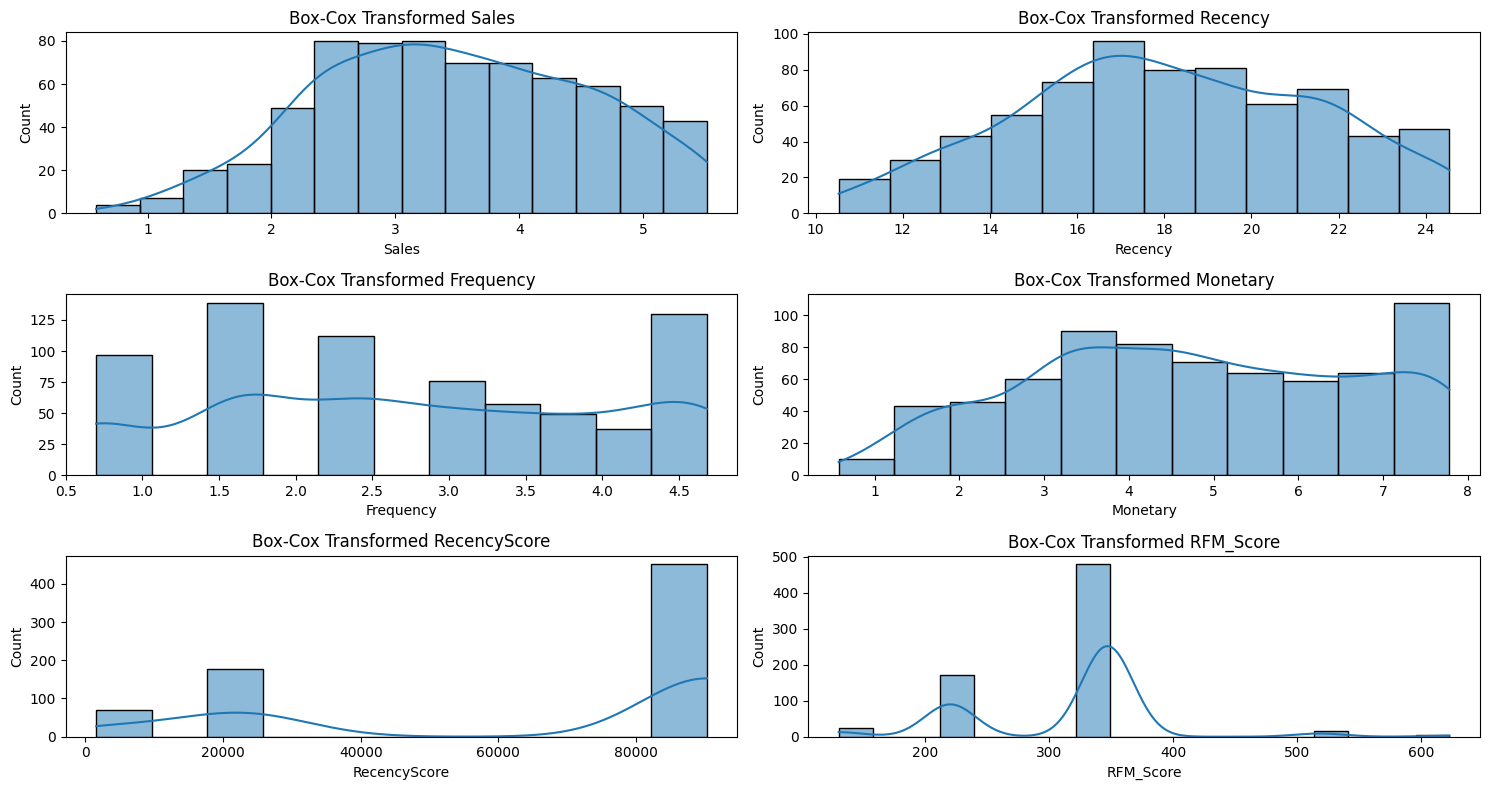

In [53]:
from scipy.stats import boxcox

# Specify the columns with right-skewed distributions
right_skewed_columns = ['Sales', 'Recency', 'Frequency', 'Monetary','RecencyScore','RFM_Score']

# Apply Box-Cox transformation to each right-skewed column
for column in right_skewed_columns:
    # Add a small constant to avoid issues with zero values
    agg_df[column] = agg_df[column] + 1
    transformed_data, lambda_value = boxcox(agg_df[column])
    agg_df[column] = transformed_data

# Visualize the transformed data
plt.figure(figsize=(15, 8))
for i, column in enumerate(right_skewed_columns, 1):
    plt.subplot(3, 2, i)
    sns.histplot(agg_df[column], kde=True)
    plt.title(f'Box-Cox Transformed {column}')

plt.tight_layout()
plt.show()

In [54]:
# from sklearn.preprocessing import StandardScalar

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [55]:
# Extract RFM columns
rfm_data = agg_df[['RecencyScore', 'FrequencyScore', 'MonetaryScore']]

# Standardize the data
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_data)

# Elbow

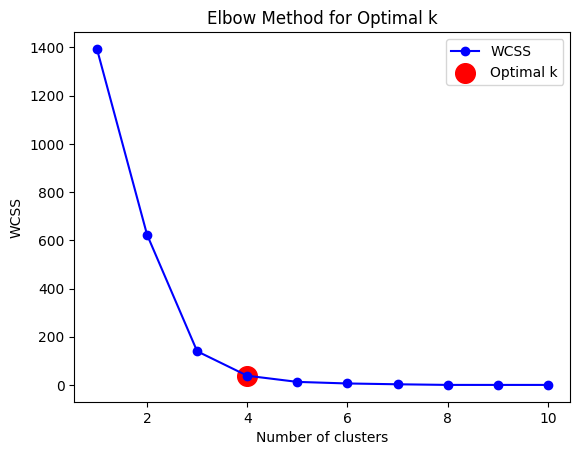

In [56]:
# Determine the optimal number of clusters using the Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Method graph with different colors
fig, ax = plt.subplots()
ax.plot(range(1, 11), wcss, marker='o', linestyle='-', color='b', label='WCSS')

# Highlight the optimal number of clusters with a different color
optimal_clusters = 4  # Change this based on your analysis
optimal_color = 'r'
ax.scatter(optimal_clusters, wcss[optimal_clusters - 1], c=optimal_color, s=200, label='Optimal k')

ax.set_title('Elbow Method for Optimal k')
ax.set_xlabel('Number of clusters')
ax.set_ylabel('WCSS')
ax.legend()
plt.show()

In [57]:
from sklearn.metrics import silhouette_score

# Assuming X is your scaled data
X = agg_df[['RecencyScore', 'FrequencyScore', 'MonetaryScore']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Try different values of K
for k in range(2, 6):
    kmeans = KMeans(n_clusters=k, random_state=0)
    agg_df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)
    
    # Evaluate clustering using silhouette score
    silhouette_avg = silhouette_score(X_scaled, agg_df['KMeans_Cluster'])
    
    print(f"For K={k}, Silhouette Score: {silhouette_avg}")

For K=2, Silhouette Score: 0.8273644800478943
For K=3, Silhouette Score: 0.9529786960684294
For K=4, Silhouette Score: 0.9720734279410561
For K=5, Silhouette Score: 0.9753851064192094


In [58]:
# Apply k-means clustering
X = agg_df[['RecencyScore', 'FrequencyScore', 'MonetaryScore']]
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=4, random_state=0)
agg_df['KMeans_Cluster'] = kmeans.fit_predict(X_scaled)

In [59]:
agg_df.head()

,Customer ID,Order Date,Customer Name,Sales,Recency,Frequency,Monetary,RecencyScore,FrequencyScore,MonetaryScore,RFM_Score,RFM Customer Segments,KMeans_Cluster
0,AA-10315,2020-04-10,Alex Avila,3.969308,20.770554,3.386263,5.698175,23032.891931,1,1,220.125230,Low Value Customer,1
1,AA-10375,2021-10-07,Allen Armold,4.551830,22.031482,4.643338,7.139233,23032.891931,1,1,220.125230,Low Value Customer,1
2,AA-10645,2021-04-07,Anna Andreadi,4.780715,22.971944,4.643338,7.358658,4327.605242,1,1,130.172884,Lost Customer,1
3,AB-10015,2021-10-11,Aaron Bergman,3.119510,15.494984,1.640307,3.670556,90283.634545,1,1,346.870115,High Value Customer,0
4,AB-10060,2021-01-09,Adam Bellavance,5.399944,23.459321,4.683214,7.782429,4327.605242,1,2,346.870115,High Value Customer,2


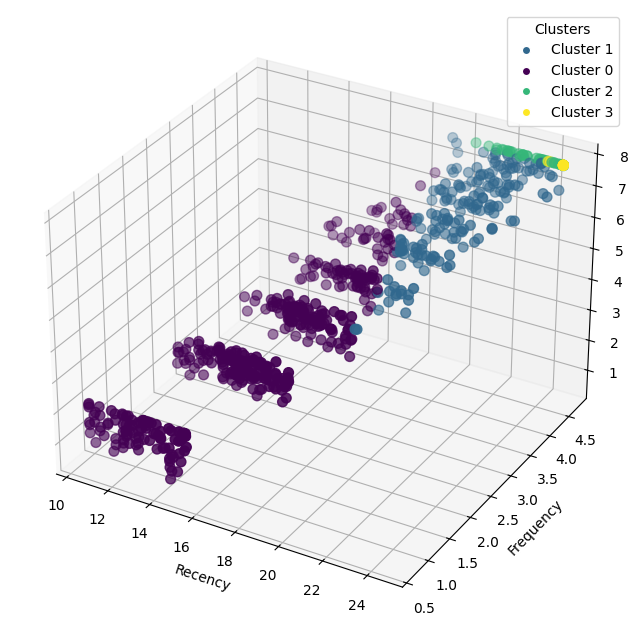

In [61]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have three dimensions: Recency, Frequency, and Monetary
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the clusters
scatter = ax.scatter(agg_df['Recency'], agg_df['Frequency'], agg_df['Monetary'], c=agg_df['KMeans_Cluster'], cmap='viridis', s=50)

# Set labels for each axis
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')

# Create a custom legend
legend_labels = agg_df['KMeans_Cluster'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {label}', markerfacecolor=scatter.to_rgba(label)) for label in legend_labels]
ax.legend(handles=legend_handles, title='Clusters')

# Show the plot
plt.show()

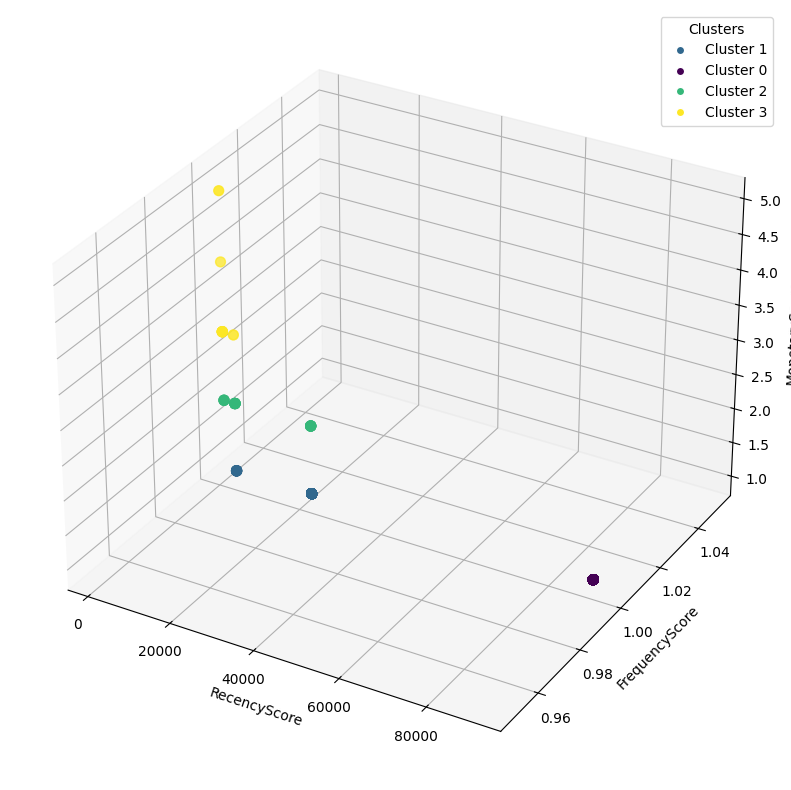

In [62]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have three dimensions: Recency, Frequency, and Monetary
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot for the clusters
scatter = ax.scatter(agg_df['RecencyScore'], agg_df['FrequencyScore'], agg_df['MonetaryScore'],
                     c=agg_df['KMeans_Cluster'], cmap='viridis', s=50)

# Set labels for each axis
ax.set_xlabel('RecencyScore')
ax.set_ylabel('FrequencyScore')
ax.set_zlabel('MonetaryScore')

# Create a custom legend
legend_labels = agg_df['KMeans_Cluster'].unique()
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=f'Cluster {label}', markerfacecolor=scatter.to_rgba(label)) for label in legend_labels]
ax.legend(handles=legend_handles, title='Clusters')

# Show the plot
plt.show()

In [63]:
import pandas as pd

# Assuming you have already applied KMeans clustering and have the 'KMeans_Cluster' column in your DataFrame
# Assuming you have already calculated RFM scores and have the 'RFM Customer Segments' column in your DataFrame

# Create a DataFrame for cluster-wise IDs
cluster_category = pd.DataFrame()
for cluster_id in agg_df['KMeans_Cluster'].unique():
    cluster_data = agg_df[agg_df['KMeans_Cluster'] == cluster_id]
    cluster_category[f'Cluster_{cluster_id}_IDs'] = cluster_data['Customer ID']

# Create a DataFrame for RFM score-wise IDs
rfm_category = pd.DataFrame()
for rfm_cat in agg_df['RFM Customer Segments'].unique():
    rfm_data = agg_df[agg_df['RFM Customer Segments'] == rfm_cat]
    rfm_category[f'RFM_{rfm_cat}_IDs'] = rfm_data['Customer ID']

# Combine both DataFrames
combined_ids = pd.DataFrame({
    'Customer ID': agg_df['Customer ID'],
    'Cluster_category': agg_df['KMeans_Cluster'],
    'RFM_category': agg_df['RFM Customer Segments']
})

# Display the combined DataFrame
combined_ids

,Customer ID,Cluster_category,RFM_category
0,AA-10315,1,Low Value Customer
1,AA-10375,1,Low Value Customer
2,AA-10645,1,Lost Customer
3,AB-10015,0,High Value Customer
4,AB-10060,2,High Value Customer
...,...,...,...
692,XP-21865,2,High Value Customer
693,YC-21895,0,High Value Customer
694,YS-21880,1,Low Value Customer
695,ZC-21910,2,Top Customer


In [64]:
from sklearn.metrics import adjusted_rand_score

# Assuming you have the true labels for comparison (e.g., true RFM segmentation)
true_labels = agg_df['RFM Customer Segments']

# Calculate Adjusted Rand Index
ari_score = adjusted_rand_score(true_labels, agg_df['KMeans_Cluster'])

print(f'Adjusted Rand Index between KMeans clustering and RFM segmentation: {ari_score}')

Adjusted Rand Index between KMeans clustering and RFM segmentation: 0.8425082772541137


In [65]:
from sklearn.metrics import adjusted_mutual_info_score

# Assuming you have the true labels for comparison (e.g., true RFM segmentation)
true_labels = agg_df['RFM Customer Segments']

# Calculate Adjusted Mutual Information
ami_score = adjusted_mutual_info_score(true_labels, agg_df['KMeans_Cluster'])

print(f'Adjusted Mutual Information between KMeans clustering and RFM segmentation: {ami_score}')

Adjusted Mutual Information between KMeans clustering and RFM segmentation: 0.7408251540611634


In [66]:
agg_df.to_csv("test_rfm.csv", index = False)

In [68]:
# Save the combined DataFrame to a CSV file
combined_ids.to_csv('combined_ids.csv', index=False)

In [ ]:
## Its test for devapp